In [55]:
import os
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pandas.plotting import table

In [28]:
rootdir = os.getcwd()

In [29]:
csvs = os.scandir(rootdir)

In [30]:
for csv in csvs:
    # Only open CSV file extensions
    if csv.name.endswith('.csv'):
        # Read the CSV file
        df = pd.read_csv(csv.path, dtype=object)

        # Drop the location column since lat, lon, and elev already exist
        if 'location' in df.columns:
            df = df.drop(['location'], axis=1).reset_index(drop=True)
        
        # Use the mean to fill in any NaNs
        df.fillna(df.mean(), inplace=True)

        # Save the cleaned files with a `clean_` prefix
        df.to_csv(os.path.join(rootdir, f"clean_{csv.name}"), index=False)

In [31]:
!ls

Untitled.ipynb                      clean_hawaii_stations.csv
clean_clean_hawaii_measurements.csv hawaii.sqlite
clean_clean_hawaii_stations.csv     hawaii_measurements.csv
clean_hawaii_measurements.csv       hawaii_stations.csv


In [32]:
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, ForeignKey
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [33]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [34]:
Base = declarative_base()

In [35]:
class Measurement(Base):
    
    __tablename__ = 'measurement'

    id = Column(Integer, primary_key=True)
    station = Column(Text)
    date = Column(Text)
    prcp = Column(Float)
    tobs = Column(Float)
    
    def __repr__(self):
        return f"id={self.id}, name={self.station}"

In [36]:
class Station(Base):
    
    __tablename__ = 'station'
    id = Column(Integer, primary_key=True)
    station = Column(Text)
    name = Column(Text)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)
    def __repr__(self):
        return f"id={self.id}, name={self.name}"

In [37]:
Base.metadata.create_all(engine)

In [38]:
engine.table_names()

['measurement', 'station']

In [39]:
def populate_table(engine, table, csvfile):
    """Populates a table from a Pandas DataFrame."""
    conn = engine.connect()

    df_of_data_to_insert = pd.read_csv(csvfile)
    
    data = df_of_data_to_insert.to_dict(orient='records')

    conn.execute(table.delete())

    conn.execute(table.insert(), data)

populate_table(engine, Station.__table__, 'clean_hawaii_stations.csv')
populate_table(engine, Measurement.__table__, 'clean_hawaii_measurements.csv')

In [40]:
engine.execute("SELECT * FROM measurement LIMIT 1").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0)]

In [41]:
engine.execute("SELECT * FROM station LIMIT 1").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [42]:
#engine = create_engine("sqlite:///hawaii.sqlite")

In [43]:
Base = automap_base()

In [44]:
Base.prepare(engine, reflect=True)

In [45]:
Base.classes.keys()

['measurement', 'station']

In [46]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [47]:
session= Session(engine)

In [48]:
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

df = pd.DataFrame(results, columns=['date', 'precipitation'])

df.set_index(['date'], inplace=True)



In [49]:
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


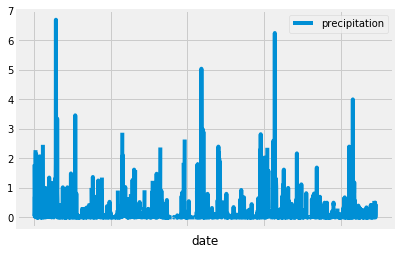

In [50]:
df = df.sort_values("date")
df.plot(x_compat=True)

In [51]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
session.query(func.count(Station.station)).all()

[(9)]

In [53]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

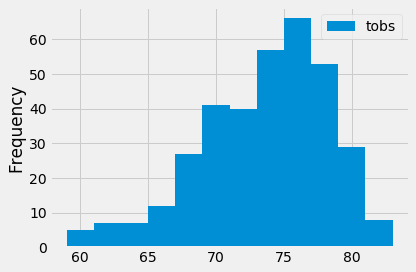

In [56]:
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [57]:
def calc_temps(start_date, end_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)


62.0 68.36585365853658 74.0


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


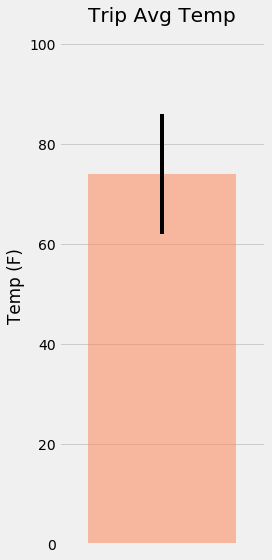

In [59]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [60]:
start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
